In [1]:
from gensim.models import Word2Vec
from gensim.models import word2vec
# from gensim.models import LDA
import gensim
import logging
import stop_words
import nltk
import string
import os
from nltk.stem import WordNetLemmatizer
import numpy as np
import pickle
import pandas as pd
import sklearn.cluster as cl
import matplotlib.pyplot as plt
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

wordnet_lemmatizer = WordNetLemmatizer()

C:\Users\joemountford\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Clustering With Word2Vec 

## aims
* compare input clusters with output clusters
* inspect output clusters manually for semantic cohesion
* check for ML problems (overfitting and shit) 

## outputs
* reccomendations on how to cluster input text and complete text of a word2vec corpus
* process for testing clusters agaisnt expected clusters

In [2]:

with open("corp.cor", "rb") as cp: 
    corp = pickle.load(cp)
with open("sentances.sent", "rb") as sent: 
    sentances = pickle.load(sent)
dictionary = gensim.corpora.dictionary.Dictionary.load("Dicktionary")

print (len(corp))
print (len(sentances))

total_words = 0
for snet in sentances: 
    for word in snet: 
        total_words += 1
        
print (total_words)

2018-04-09 13:13:44,752 : INFO : loading Dictionary object from Dicktionary
2018-04-09 13:13:44,763 : INFO : loaded Dicktionary


24082
24082
1127376


In [3]:
#train dataset
num_features = 300    # Word vector dimensionality
min_word_count = 2  # Minimum word count
num_workers = 10       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-2



model = Word2Vec(sentances, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling, seed=1)

2018-04-09 13:13:44,889 : INFO : collecting all words and their counts
2018-04-09 13:13:44,891 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-09 13:13:45,008 : INFO : PROGRESS: at sentence #10000, processed 534924 words, keeping 15463 word types
2018-04-09 13:13:45,091 : INFO : PROGRESS: at sentence #20000, processed 959557 words, keeping 18833 word types
2018-04-09 13:13:45,121 : INFO : collected 20016 word types from a corpus of 1127376 raw words and 24082 sentences
2018-04-09 13:13:45,123 : INFO : Loading a fresh vocabulary
2018-04-09 13:13:45,226 : INFO : min_count=2 retains 14068 unique words (70% of original 20016, drops 5948)
2018-04-09 13:13:45,228 : INFO : min_count=2 leaves 1121428 word corpus (99% of original 1127376, drops 5948)
2018-04-09 13:13:45,287 : INFO : deleting the raw counts dictionary of 20016 items
2018-04-09 13:13:45,288 : INFO : sample=0.01 downsamples 4 most-common words
2018-04-09 13:13:45,289 : INFO : downsampling leaves 

we want to build a vocab to test against the word2vec model. I did try using the entire model.wv.vocab but it's huge and slow. 

In [4]:
# model.wv.similar_by_word("innocent")
vocab = [x[0] for x in model.wv.similar_by_word("delicious", topn = 30)]
print(vocab)
[vocab.append(x[0]) for x in model.wv.similar_by_word("customer", topn = 30)]
[vocab.append(x[0]) for x in model.wv.similar_by_word("thirsty", topn = 30)]

# print(vocab)

init_tag = [0 for x in range(30)]
[init_tag.append(1) for x in range(30)]
[init_tag.append(2) for x in range(30)]

2018-04-09 13:13:54,116 : INFO : precomputing L2-norms of word weight vectors


['tasty', 'yummy', 'fruity', 'berry', 'protein', 'green', 'yum', 'vitamin', 'super', 'invigorate', 'vegetable', 'pomegranate', 'fruit', 'veggie', 'mango', 'pink', 'nutritious', 'tropical', 'fresh', 'recharge', 'antioxidant', 'detox', 'pineapple', 'ginger', 'foodie', 'kiwi', 'strawberry', 'refreshing', 'homemade', 'mackerel']


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

we want to build a similarity matrix for training with in sklearn so lets iterate through ever term and compare it to every other term. 

super pretty code right here /s

In [5]:
term1l = []
term2l = []
similarity = []
avg_len = []

for num, term in enumerate(vocab):
    now = datetime.datetime.now()
    for term2 in vocab: 
        term1l.append(term)
        term2l.append(term2)
        similarity.append(model.similarity(term, term2))
    avg_len.append((len(model.wv.vocab) - num) * (datetime.datetime.now() - now))
     
        


In [6]:
sim_df =pd.DataFrame()
sim_df["term_1"] = term1l
sim_df["term_2"] = term2l
sim_df["similarity"] = similarity


In [7]:
sim_p = sim_df.pivot(index = "term_1", columns = "term_2", values = "similarity")

print(sim_p)

term_2        account  antioxidant   bangkok  bartender      beer     berry  \
term_1                                                                        
account      1.000000     0.135022  0.174825   0.200267 -0.020991  0.196912   
antioxidant  0.135022     1.000000  0.660899   0.545083  0.320534  0.885514   
bangkok      0.174825     0.660899  1.000000   0.698310  0.410700  0.550554   
bartender    0.200267     0.545083  0.698310   1.000000  0.695943  0.547089   
beer        -0.020991     0.320534  0.410700   0.695943  1.000000  0.350765   
berry        0.196912     0.885514  0.550554   0.547089  0.350765  1.000000   
blast        0.670672     0.283807  0.340867   0.529689  0.196456  0.374186   
booty        0.530608     0.662508  0.719363   0.608518  0.292928  0.672647   
brewed       0.621419     0.476168  0.528601   0.622006  0.274417  0.523860   
broth        0.130250     0.643769  0.752127   0.798152  0.683437  0.668791   
cash         0.539669     0.326205  0.419655   0.543

and now the moneyshot

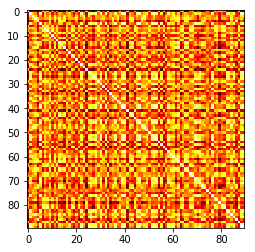

In [8]:
plt.imshow(sim_p,cmap='hot',interpolation='nearest')
plt.show()

## clustering

now we've got our datasets for inputting, lets get our outputs from the sklearn systems. 

### clustering models to use
* SpectralClustering
* Kmeans
* MiniBatchKmeans
* DBSCAN - tried but mostly -1s :(

In [9]:
from sklearn.cluster import SpectralClustering

simcluster1 = SpectralClustering(3).fit_predict(sim_p)

print(sim_p.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster1, sim_p.columns.values):
#     print(y, x)
    
test_df = pd.DataFrame()

test_df["term"] = sim_p.columns.values
test_df["sim_matrixcluster"] = simcluster1

['account' 'antioxidant' 'bangkok' 'bartender' 'beer' 'berry' 'blast'
 'booty' 'brewed' 'broth' 'cash' 'champagne' 'chat' 'cocktail' 'coffee'
 'cognac' 'competition' 'condiment' 'cracking' 'dean' 'decaf' 'desk'
 'detox' 'dinnertime' 'employee' 'foodie' 'fresh' 'fruit' 'fruity' 'gig'
 'ginger' 'glutton' 'green' 'gullible' 'hearties' 'herbal' 'homemade'
 'imbibe' 'initiative' 'invigorate' 'kiwi' 'lad' 'lemonade' 'liquor'
 'loan' 'mackerel' 'mango' 'martini' 'nightlife' 'nutritious' 'partner'
 'pineapple' 'pink' 'pomegranate' 'portico' 'protein' 'quest' 'rarely'
 'recharge' 'refreshing' 'relax' 'responsibly' 'rum' 'scraped' 'seal'
 'slurp' 'soft' 'spark' 'statue' 'strawberry' 'super' 'tasty' 'tea'
 'tequila' 'textile' 'tipsy' 'tropical' 'tunnel' 'turban' 'tweet'
 'underground' 'uniform' 'vegetable' 'veggie' 'vermouth' 'vitamin' 'wine'
 'youngster' 'yum' 'yummy']


In [10]:
#lets try using the 300 row thing 

modeldf = pd.DataFrame(model.wv.syn0)
modeldf.index = model.wv.vocab

modeldf = modeldf[(modeldf.index.isin(vocab))]

print(len(modeldf))

90


In [11]:
simcluster2 = SpectralClustering(3).fit_predict(modeldf)

print(modeldf.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster2, modeldf.columns.values):
#     print(y, x)
    
test_df["vector_cluster"] = simcluster2

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [12]:
test_df["original_cluster"] = init_tag
print(test_df)
# test_df.to_csv("cluster_output.csv")

           term  sim_matrixcluster  vector_cluster  original_cluster
0       account                  0               1                 0
1   antioxidant                  1               1                 0
2       bangkok                  2               1                 0
3     bartender                  2               1                 0
4          beer                  2               1                 0
5         berry                  1               1                 0
6         blast                  0               1                 0
7         booty                  0               1                 0
8        brewed                  0               1                 0
9         broth                  2               1                 0
10         cash                  0               1                 0
11    champagne                  2               1                 0
12         chat                  0               1                 0
13     cocktail                  2

In [13]:
from sklearn.cluster import MiniBatchKMeans

simcluster1 = MiniBatchKMeans(3).fit_predict(sim_p)

print(sim_p.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster1, sim_p.columns.values):
#     print(y, x)
    
# test_df = pd.DataFrame()

test_df["sim_matrix_kmeans_cluster"] = simcluster1

['account' 'antioxidant' 'bangkok' 'bartender' 'beer' 'berry' 'blast'
 'booty' 'brewed' 'broth' 'cash' 'champagne' 'chat' 'cocktail' 'coffee'
 'cognac' 'competition' 'condiment' 'cracking' 'dean' 'decaf' 'desk'
 'detox' 'dinnertime' 'employee' 'foodie' 'fresh' 'fruit' 'fruity' 'gig'
 'ginger' 'glutton' 'green' 'gullible' 'hearties' 'herbal' 'homemade'
 'imbibe' 'initiative' 'invigorate' 'kiwi' 'lad' 'lemonade' 'liquor'
 'loan' 'mackerel' 'mango' 'martini' 'nightlife' 'nutritious' 'partner'
 'pineapple' 'pink' 'pomegranate' 'portico' 'protein' 'quest' 'rarely'
 'recharge' 'refreshing' 'relax' 'responsibly' 'rum' 'scraped' 'seal'
 'slurp' 'soft' 'spark' 'statue' 'strawberry' 'super' 'tasty' 'tea'
 'tequila' 'textile' 'tipsy' 'tropical' 'tunnel' 'turban' 'tweet'
 'underground' 'uniform' 'vegetable' 'veggie' 'vermouth' 'vitamin' 'wine'
 'youngster' 'yum' 'yummy']


In [14]:
simcluster2 = MiniBatchKMeans(3).fit_predict(modeldf)

print(modeldf.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster2, modeldf.columns.values):
#     print(y, x)
    
test_df["kmeans_vector_cluster"] = simcluster2

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [15]:
from sklearn.cluster import KMeans

simcluster1 = KMeans(3).fit_predict(sim_p)

# print(sim_p.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster1, sim_p.columns.values):
#     print(y, x)
    
# test_df = pd.DataFrame()

test_df["sim_matrix_kmeans_maxi_cluster"] = simcluster1

In [16]:
simcluster2 = KMeans(3).fit_predict(modeldf)

print(modeldf.columns.values)

# print(dir(model))
# print(model)

# for x, y in zip(simcluster2, modeldf.columns.values):
#     print(y, x)
    
test_df["kmeans_maxi_vector_cluster"] = simcluster2

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [18]:
test_df.to_csv("cluster_output.csv")

and then let's look at that cvs to manually check out what it looks like! 